### Описание задачи
Проанализировать данные о пользователях сервиса аренды самокатов из нескольких городов, а также об их поездках, и проверить гипотезы, которые могут помочь бизнесу вырасти.
### Цели исследования
1. Определить частоту встречаемости городов.
2. Выявить соотношение пользователей с подпиской и без подписки.
3. Проанализировать возраст пользователей, расстояние, которое пользователь преодолел за одну поездку, и продолжительность поездок.
4. Подсчитать помесячную выручку от пользователей с подпиской и без подписки.
5. Проверить несколько гипотез для планируемого запуска промоакций, стимулирующих пользователей покупать подписку.

### Ход исследования
1. Загрузка и обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Преобразование данных.
5. Подсчёт выручки.
6. Проверка гипотез.

# Загрузка и обзор данных

In [320]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [321]:
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv', parse_dates=['date'])
subs = pd.read_csv('subscriptions_go.csv')

In [322]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [323]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [324]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [325]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [326]:
subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [327]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Как мы видим по результатам вывода методов info() и head(), все три датафрейма не имеют нулевых или отсутствующих значений, типы данных не требуют форматирования, а структура и содержание данных на первый взгляд представляются понятными и пока что не вызывают вопросов.

# Предобработка данных

In [328]:
# Прежде, чем приступить к созданию нового столбца, проверим временной интервал имеющихся в столбце date значений.
print(rides['date'].min())
print(rides['date'].max())

2021-01-01 00:00:00
2021-12-30 00:00:00


In [329]:
# Создаём новый столбец с номером месяца.
rides['month'] = rides['date'].dt.month
rides['month']

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: month, Length: 18068, dtype: int64

In [330]:
# Используя сочетание метода isna() и функции sum(), выводим количество пропущенных значений в датафрейме users.
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [331]:
# В датафрейме rides.
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [332]:
# И в subs.
subs.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

## Пропущенные значения
Видим, что пропусков нет. Идём дальше.

In [333]:
# Приступаем к работе с дубликатами. Методом duplicated() в сочетании с sum() проверим наличие явных дубликатов в users.
users.duplicated().sum()

31

In [334]:
# В rides.
rides.duplicated().sum()

0

In [335]:
# И subs.
subs.duplicated().sum()

0

In [336]:
# Явные дубликаты нашлись только в датафрейме users. Удаляем их методом drop_duplicates() и убеждаемся, что дубликатов нет.
users.drop_duplicates(inplace=True)
users.duplicated().sum()

0

## Дубликаты
В *users* была удалена 31 строка-дубликат, в других датафреймах явных дубликатов обнаружено не было.

Исходя из особенностей датафреймов — а именно уникальности значений в столбцах, — проверять их на наличие неявных дубликатов не имеет смысла.

# Исследовательский анализ данных

## Частота встречаемости городов

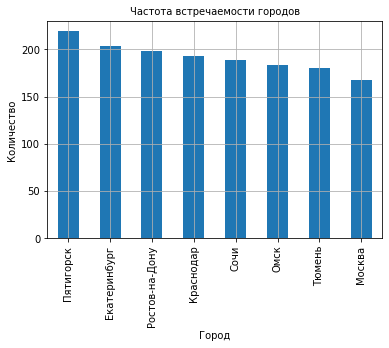

In [337]:
# Воспользуемся методом value_counts(), чтобы подсчитать уникальные значения в столбце city датафрейма users.
# И построим столбчатую диаграмму (bar) на основе данных выше, чтобы посмотреть частоту встречаемости городов.
(
    users['city']
    .value_counts()
    .plot(kind='bar',
          rot=90,
          legend=False,
          grid=True)
)

plt.title('Частота встречаемости городов', fontsize=10)
plt.xlabel('Город', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.show()

### Вывод
Разброс небольшой, сервис в представленных городах работает примерно на одном уровне. В лидерах Пятигорск, в целом превалируют регионы, Москва на последнем месте, но отрыв от первого нельзя назвать огромным.

## Соотношение пользователей с подпиской и без подписки

In [338]:
# Посмотрим на соотношение пользователей — количественное и процентное.
print('Количество пользователей с подпиской и без подписки:')
print(users['subscription_type'].value_counts().to_string(index=False))
print()
print('Доля пользователей с подпиской и без подписки:')
print(users['subscription_type'].value_counts(normalize=True).to_string(index=False))

Количество пользователей с подпиской и без подписки:
835
699

Доля пользователей с подпиской и без подписки:
0.544329
0.455671


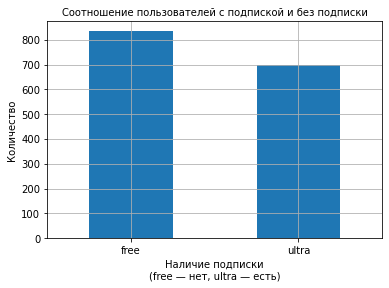

In [339]:
# И построим столбчатую диаграмму.
(
    users['subscription_type']
    .value_counts()
    .plot(kind='bar',
          rot=0,
          legend=False,
          grid=True)
)

plt.title('Соотношение пользователей с подпиской и без подписки', fontsize=10)
plt.xlabel('Наличие подписки\n(free — нет, ultra — есть)', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.show()

### Вывод
Пользователей без подписки больше, но не намного. В целом это может говорить о достаточно высоком уровне лояльности.

## Возраст пользователей

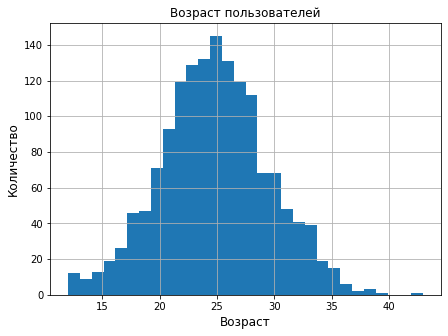

In [340]:
# Функцией hist() построим гистограмму.
# Гистограмма позволяет визуализировать распределение возрастов
# И получить представление о том, как они распределены в определенных интервалах.
users['age'].hist(bins=30, figsize=(7, 5))

plt.title('Возраст пользователей', fontsize=12)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.show()

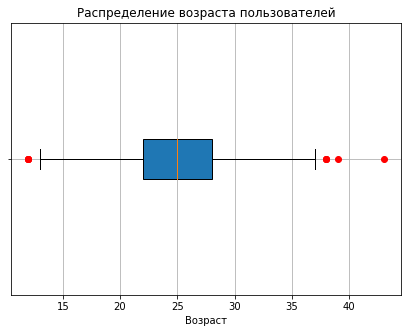

In [341]:
# Построим боксплот («ящик с усами»), чтобы посмотреть на распределение данных в users['age'].
plt.figure(figsize=(7, 5))

plt.boxplot(
    users['age'],
    sym='ro',
    vert=False,
    patch_artist=True
)

plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.yticks([1], [''])
plt.grid(True)
plt.show()

### Вывод
Большая часть пользователей находится в диапазоне 22–28 лет. Медиана — 25 лет, меньше 15 и больше 40 лет — редкие значения.

Так как гистограмма имеет колоколообразную форму с пиком в центре и относительно симметричными хвостами, можно сказать, что распределение данных в столбце *age* является нормальным.

## Расстояние, которое пользователь преодолел за одну поездку

In [342]:
# Методом describe() посмотрим общую статистику по столбцу distance.
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

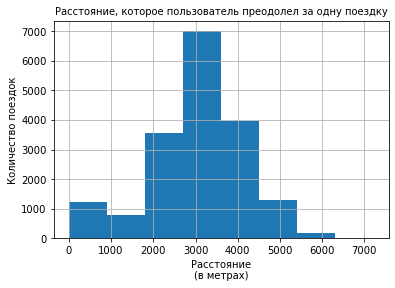

In [343]:
rides['distance'].hist(bins=8)

plt.title('Расстояние, которое пользователь преодолел за одну поездку', fontsize=10)
plt.xlabel('Расстояние\n(в метрах)', fontsize=10)
plt.ylabel('Количество поездок', fontsize=10)
plt.show()

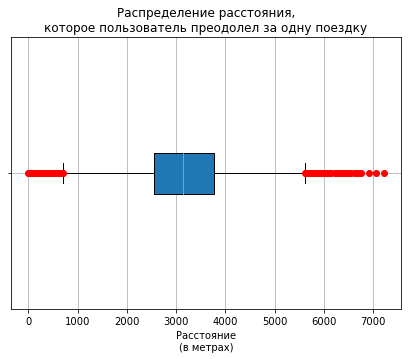

In [344]:
# Также построим боксплот, чтобы посмотреть на распределение данных.
plt.figure(figsize=(7, 5))

plt.boxplot(
    rides['distance'],
    sym='ro',
    vert=False,
    patch_artist=True
)

plt.title('Распределение расстояния,\nкоторое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние\n(в метрах)')
plt.yticks([1], [''])
plt.grid(True)
plt.show()

### Вывод
Большинство поездок были совершены на расстояние от 2500 до 3800 метров. Медиана — 3133 м. Поездки на расстояние более 5000 метров редки. При этом на гистограмме видно, что часть пользователей использует самокаты для коротких поездок — до 1500 м.

## Продолжительность поездок

In [345]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

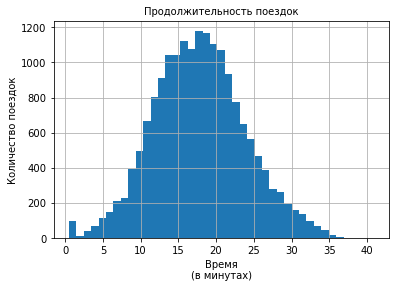

In [346]:
rides['duration'].hist(bins=41)

plt.title('Продолжительность поездок', fontsize=10)
plt.xlabel('Время\n(в минутах)', fontsize=10)
plt.ylabel('Количество поездок', fontsize=10)
plt.show()

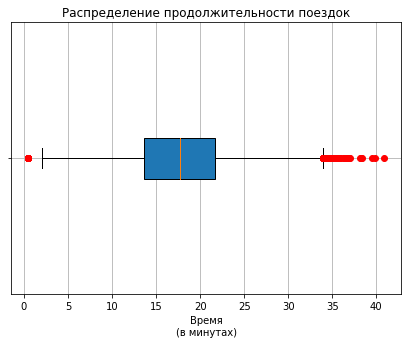

In [347]:
# И построим боксплот для rides['duration'].
plt.figure(figsize=(7, 5))

plt.boxplot(
    rides['duration'],
    sym='ro',
    vert=False,
    patch_artist=True
)

plt.title('Распределение продолжительности поездок')
plt.xlabel('Время\n(в минутах)')
plt.yticks([1], [''])
plt.grid(True)
plt.show()

### Вывод
Продолжительность большинства поездок — 15–20 минут. Медиана — 17 минут. Поездки короче 5 минут и дольше 30 минут редки.

# Объединение данных

## Создание объединённого датафрейма

In [348]:
# Проведём проверку размерности для обеспечения корректности операций с данными и предотвращения потенциальных ошибок.
# Проверим размеры и столбцы датафреймов users, rides и subs до объединения.
print('Размер датафрейма users до объединения:', users.shape)
print('Столбцы датафрейма users до объединения:', users.columns.tolist())
print()
print('Размер датафрейма rides до объединения:', rides.shape)
print('Столбцы датафрейма rides до объединения:', rides.columns.tolist())
print()
print('Размер датафрейма subs до объединения:', subs.shape)
print('Столбцы датафрейма subs до объединения:', subs.columns.tolist())

Размер датафрейма users до объединения: (1534, 5)
Столбцы датафрейма users до объединения: ['user_id', 'name', 'age', 'city', 'subscription_type']

Размер датафрейма rides до объединения: (18068, 5)
Столбцы датафрейма rides до объединения: ['user_id', 'distance', 'duration', 'date', 'month']

Размер датафрейма subs до объединения: (2, 4)
Столбцы датафрейма subs до объединения: ['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']


In [349]:
# Объединим данные в один датафрейм с помощью метода merge().
df = users.merge(rides, on='user_id').merge(subs, on='subscription_type')
df

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [350]:
# И проверим размер результирующего датафрейма df.
print('Размер результирующего датафрейма df:', df.shape)
print('Столбцы результирующего датафрейма df:', df.columns.tolist())

Размер результирующего датафрейма df: (18068, 12)
Столбцы результирующего датафрейма df: ['user_id', 'name', 'age', 'city', 'subscription_type', 'distance', 'duration', 'date', 'month', 'minute_price', 'start_ride_price', 'subscription_fee']


#### Результаты проверки размерности
После объединения мы получили результирующий датафрейм, состоящий из 18 068 строк — как самый длинный датафрейм, subs — и включающий в себя 10 столбцов — на два меньше, чем общее количество столбцов в трёх датафреймах, так как столбцы user_id и subscription_type использовались для объединения датафреймов методов merge().

Соответственно, проверка размерности пройдена.

## Создание новых датафреймов

In [351]:
# Создадим из созданного датафрейма ещё два: с данными о пользователях без подписки и с данными о пользователях с подпиской.
# Сделаем это с помощью логической индексации.
# И зададим новую индексацию датафреймов с помощью метода reset_index().
df_ultra = df.loc[df['subscription_type'] == 'ultra'].reset_index(drop=True)
df_free = df.loc[df['subscription_type'] == 'free'].reset_index(drop=True)

In [352]:
# Методом drop() удалим из обоих датафреймов столбец subscription_type.
df_ultra.drop('subscription_type', axis=1, inplace=True)
df_free.drop('subscription_type', axis=1, inplace=True)

In [353]:
df_ultra.head()

,user_id,name,age,city,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,4028.687306,26.265803,2021-08-28,8,6,0,199


In [354]:
df_free.head()

,user_id,name,age,city,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,3047.379435,17.427673,2021-02-14,2,8,50,0


## Расстояние и время поездок для обеих категорий

In [355]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

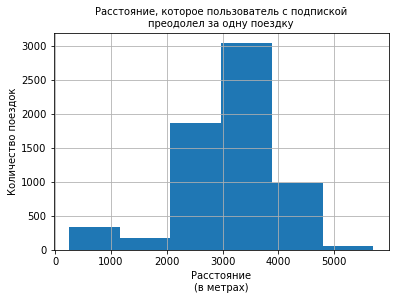

In [356]:
df_ultra['distance'].hist(bins=6)

plt.title('Расстояние, которое пользователь с подпиской\nпреодолел за одну поездку', fontsize=10)
plt.xlabel('Расстояние\n(в метрах)', fontsize=10)
plt.ylabel('Количество поездок', fontsize=10)
plt.show()

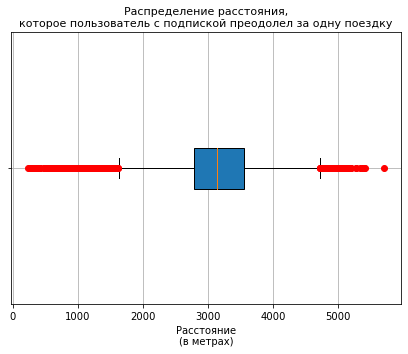

In [357]:
# Построим боксплот и посмотрим на распределение расстояния, которое пользователь с подпиской преодолел за одну поездку.
plt.figure(figsize=(7, 5))

plt.boxplot(
    df_ultra['distance'],
    sym='ro',
    vert=False,
    patch_artist=True
)

plt.title('Распределение расстояния,\nкоторое пользователь с подпиской преодолел за одну поездку', fontsize=11)
plt.xlabel('Расстояние\n(в метрах)')
plt.yticks([1], [''])
plt.grid(True)
plt.show()

Пользователи с подпиской в большинстве своём совершают поездки на расстояние 2800–3500 метров. У них немного коротких поездок и слишком длинных. Поездки на дистанции короче 1800 и длинее 4800 метров — редкость для подписчиков.

In [358]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

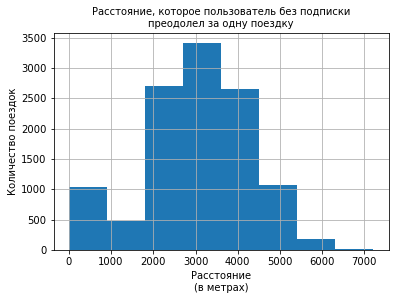

In [359]:
df_free['distance'].hist(bins=8)

plt.title('Расстояние, которое пользователь без подписки\nпреодолел за одну поездку', fontsize=10)
plt.xlabel('Расстояние\n(в метрах)', fontsize=10)
plt.ylabel('Количество поездок', fontsize=10)
plt.show()

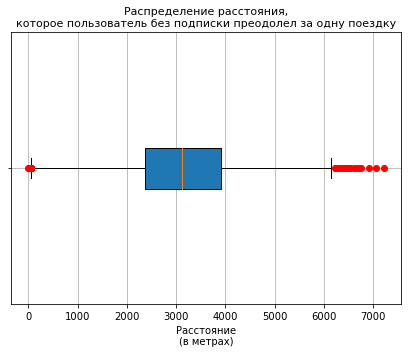

In [360]:
# И построим такой же боксплот для, чтобы посмотреть распределение среди пользователей без подписки.
plt.figure(figsize=(7, 5))

plt.boxplot(
    df_free['distance'],
    sym='ro',
    vert=False,
    patch_artist=True
)

plt.title('Распределение расстояния,\nкоторое пользователь без подписки преодолел за одну поездку', fontsize=11)
plt.xlabel('Расстояние\n(в метрах)')
plt.yticks([1], [''])
plt.grid(True)
plt.show()

Пользователи без подписки в основном совершают поездки в диапазоне от 2300 до 3900 метров. При этом они чаще пользователей с подпиской отправляются в путь и на совсем короткие расстояния, и на самые длинные дистанции — от меньше чем 1 до более чем 6000 м — в представленной генеральной совокупности.

In [361]:
df_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

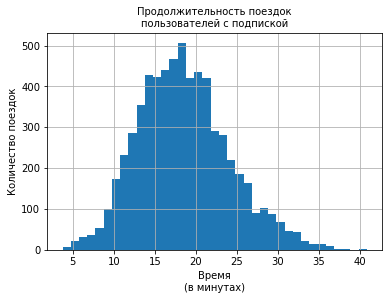

In [362]:
df_ultra['duration'].hist(bins=37)

plt.title('Продолжительность поездок\nпользователей с подпиской', fontsize=10)
plt.xlabel('Время\n(в минутах)', fontsize=10)
plt.ylabel('Количество поездок', fontsize=10)
plt.show()

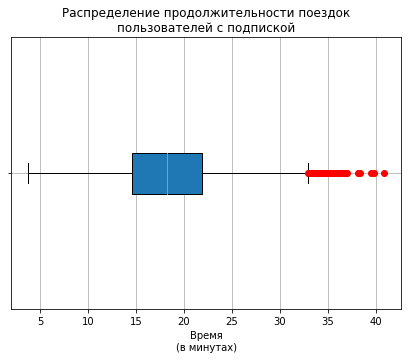

In [363]:
# И боксплот для распределения продолжительности поездок пользователей с подпиской.
plt.figure(figsize=(7, 5))

plt.boxplot(
    df_ultra['duration'],
    sym='ro',
    vert=False,
    patch_artist=True
)

plt.title('Распределение продолжительности поездок\nпользователей с подпиской')
plt.xlabel('Время\n(в минутах)')
plt.yticks([1], [''])
plt.grid(True)
plt.show()

Подписчики в основном тратят на поездки от 14 до 22 минут. Для них редки поездки меньше 4 и дольше 33 минут.

In [364]:
df_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

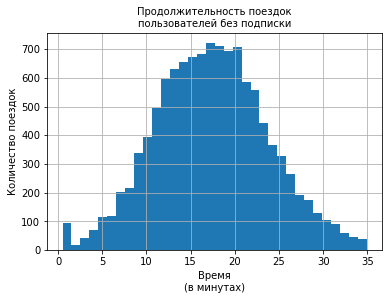

In [365]:
df_free['duration'].hist(bins=34)

plt.title('Продолжительность поездок\nпользователей без подписки', fontsize=10)
plt.xlabel('Время\n(в минутах)', fontsize=10)
plt.ylabel('Количество поездок', fontsize=10)
plt.show()

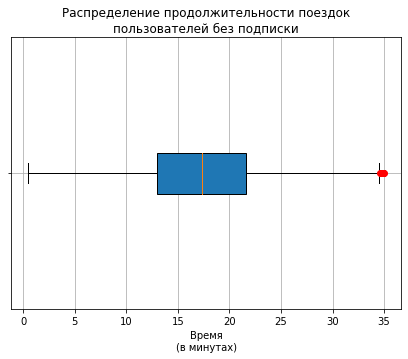

In [366]:
# И боксплот для пользователей без подписки.
plt.figure(figsize=(7, 5))

plt.boxplot(
    df_free['duration'],
    sym='ro',
    vert=False,
    patch_artist=True
)

plt.title('Распределение продолжительности поездок\nпользователей без подписки')
plt.xlabel('Время\n(в минутах)')
plt.yticks([1], [''])
plt.grid(True)
plt.show()

По большей части продолжительность поездок пользователей без подписки составляет от 13 до 21 минуты. Однако в целом разброс продолжительности поездок варьируется от меньше чем 1 до практически 35 минут.

# Подсчёт выручки

In [367]:
# Округляем продолжительность каждой поездки с помощью метода «потолок» — np.ceil() — библиотеки NumPy.
# И методом astype() приводим округлённые значения в столбце к формату int.
df['duration'] = np.ceil(df['duration']).astype(int)
df['duration']

0        26
1        16
2         7
3        19
4        27
         ..
18063    20
18064    22
18065    19
18066    17
18067    16
Name: duration, Length: 18068, dtype: int64

In [368]:
# Создадим датафрейм с агрегированными данными о поездках на основе df — датафрейма с объединёнными данными.
df_grouped = df.groupby(
    ['user_id',
     'month',
     'start_ride_price',
     'minute_price',
     'subscription_fee']
).agg({
    'distance': 'sum',
    'duration': 'sum',
    'user_id': 'count'
}).rename(columns={'user_id': 'ride_count'}).reset_index()

# Переименовываем столбцы.
df_grouped.rename(columns={'distance': 'monthly_distance',
                           'duration': 'monthly_duration'}, inplace=True)

# Проверим сводную таблицу на пропуски.
df_grouped.isna().sum()

user_id             0
month               0
start_ride_price    0
minute_price        0
subscription_fee    0
monthly_distance    0
monthly_duration    0
ride_count          0
dtype: int64

In [369]:
# Считаем помесячную выручку.
df_grouped['monthly_revenue'] = (df_grouped['start_ride_price'] * df_grouped['ride_count']) +\
                                (df_grouped['minute_price'] * df_grouped['monthly_duration']) +\
                                df_grouped['subscription_fee']

# И выводим получившуюся сводную таблицу на экран.
df_grouped

,user_id,month,start_ride_price,minute_price,subscription_fee,monthly_distance,monthly_duration,ride_count,monthly_revenue
0,1,1,0,6,199,7027.511294,42,2,451
1,1,4,0,6,199,754.159807,7,1,241
2,1,8,0,6,199,6723.470560,46,2,475
3,1,10,0,6,199,5809.911100,32,2,391
4,1,11,0,6,199,7003.499363,56,3,535
...,...,...,...,...,...,...,...,...,...
11326,1534,6,50,8,0,3409.468534,26,2,308
11327,1534,8,50,8,0,7622.453034,48,2,484
11328,1534,9,50,8,0,4928.173852,23,1,234
11329,1534,11,50,8,0,13350.015305,78,4,824


In [370]:
# Проверяем типы данных в сгруппированном датафрейме.
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           11331 non-null  int64  
 1   month             11331 non-null  int64  
 2   start_ride_price  11331 non-null  int64  
 3   minute_price      11331 non-null  int64  
 4   subscription_fee  11331 non-null  int64  
 5   monthly_distance  11331 non-null  float64
 6   monthly_duration  11331 non-null  int64  
 7   ride_count        11331 non-null  int64  
 8   monthly_revenue   11331 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 796.8 KB


# Проверка гипотез

## Тратят ли пользователи с подпиской больше времени на поездки?
Сформулируем нулевую и альтернативную гипотезы, где:
- H₀ — нулевая гипотеза;
- H₁ — альтернативная гипотеза;
- μ₁ — среднее генеральной совокупности Время поездок пользователей с подпиской;
- μ₂ — среднее генеральной совокупности Время поездок пользователей без подписки.

H₀: μ₁ > μ₂;

H₁: μ₁ <= μ₂.

In [371]:
# Соберём данные продолжительности поездок для пользователей с подпиской и без подписки.
ultra_duration = df.loc[df['subscription_type'] == 'ultra']['duration']
free_duration = df.loc[df['subscription_type'] == 'free']['duration']

# Зададим уровень статистической значимости.
alpha = 0.05

# Запускаем t-тест для двух независимых генеральных совокупностей — ultra_duration и free_duration.
results = st.ttest_ind(ultra_duration, free_duration, alternative='greater')
print('p-значение:', results.pvalue)

# Сравниваем полученное в результате t-теста значение p-value с уровнем статистической значимости.
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу. Пользователи без подписки тратят больше времени на поездки')
else:
    print('Не отвергаем нулевую гипотезу. Пользователи с подпиской тратят больше времени на поездки')

p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу. Пользователи без подписки тратят больше времени на поездки


### Вывод
2.4959453720736625e-34 — число в экспоненциальном виде, где *-34* — показатель степени. Значит, оно эквивалентно очень малому числу, близкому к нулю.

Это говорит о том, что у нас есть статистически значимымые доказательства, позволяющие отвергнуть нулевую гипотезу. Потому что вероятность получить наблюдаемое или ещё более далёкое от предполагаемого в нулевой гипотезе значения при условии, что нулевая гипотеза верна, крайне низка. Это позволяет нам отвергнуть нулевую гипотезу.

Поэтому можно сказать, что *пользователи с подпиской не тратят больше времени на поездки.*

## Не превышает ли расстояние, которое проезжают пользователи с подпиской за одну поездку, 3130 метров?
Сформулируем нулевую и альтернативную гипотезы, где:
- H₀ — нулевая гипотеза;
- H₁ — альтернативная гипотеза;
- μ — расстояние, которое проезжают пользователи с подпиской за одну поездку;
- 3130 — расстояние одной поездки, оптимальное с точки зрения износа самоката.

H₀: μ <= 3130;

H₁: μ > 3130.

In [372]:
# Соберём данные о расстоянии поездок для пользователей с подпиской.
ultra_distance = df.loc[df['subscription_type'] == 'ultra']['distance']

# Оптимальное расстояние с точки зрения износа самоката.
optimal_distance = 3130

# Уровень статистической значимости.
alpha = 0.05

# t-тест для среднего генеральной совокупности ultra_distance и значения optimal_distance.
results = st.ttest_1samp(ultra_distance, optimal_distance, alternative='greater')
print('p-значение:', results.pvalue)

# Сравниваем значение p-value с уровнем статистической значимости.
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу. Расстояние, которое пользователи с подпиской проезжают за одну поездку, превышает 3130 метров')
else:
    print('Не отвергаем нулевую гипотезу. Расстояние, которое пользователи с подпиской проезжают за одну поездку, не превышает 3130 метров')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу. Расстояние, которое пользователи с подпиской проезжают за одну поездку, не превышает 3130 метров


### Вывод
p-значение равное 0.9195368847849785 говорит о том, что у нас нет статистически значимымых доказательств, позволяющих отвергнуть нулевую гипотезу. Вероятность получить наблюдаемое или ещё более далёкое от предполагаемого в нулевой гипотезе значения при условии, что нулевая гипотеза верна, равна ~91%.

Поэтому можно сказать, что *расстояние, которое пользователи с подпиской проезжают за одну поездку, не превышает 3130 метров.*

## Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
Сформулируем нулевую и альтернативную гипотезы, где:
- H₀ — нулевая гипотеза;
- H₁ — альтернативная гипотеза;
- μ₁ — среднее генеральной совокупности Помесячная выручка от пользователей с подпиской по месяцам;
- μ₂ — среднее генеральной совокупности Помесячная выручка от пользователей без подписки по месяцам.

H₀: μ₁ > μ₂;

H₁: μ₁ <= μ₂.

In [373]:
# Данные помесячной выручки от пользователей с подпиской по месяцам.
ultra_monthly_revenue = df_grouped.loc[df_grouped['subscription_fee'] == 199]['monthly_revenue']
# И данные помесячной выручки от пользователей без подписки.
free_monthly_revenue = df_grouped.loc[df_grouped['subscription_fee'] == 0]['monthly_revenue']

# Уровень статистической значимости.
alpha = 0.05

# t-тест для двух независимых генеральных совокупностей — ultra_monthly_revenue и free_monthly_revenue.
results = st.ttest_ind(ultra_monthly_revenue, free_monthly_revenue, alternative='greater')
print('p-значение:', results.pvalue)

# Сравниваем p-value с уровнем статистической значимости.
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу. Помесячная выручка от пользователей без подписки по месяцам будет выше, чем выручка от пользователей с подпиской.')
else:
    print('Не отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки.')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу. Помесячная выручка от пользователей без подписки по месяцам будет выше, чем выручка от пользователей с подпиской.


### Вывод
p-значение равное 1.8850394384715216e-31 близко к нулю. Значит, что у нас есть статистически значимымые доказательства, позволяющие отвергнуть нулевую гипотезу. Потому что вероятность получить наблюдаемое или ещё более далёкое от предполагаемого в нулевой гипотезе значения при условии, что нулевая гипотеза верна, крайне низка.

Можно сказать, что *помесячная выручка от пользователей с подпиской по месяцам не будет выше, чем выручка от пользователей без подписки*.

## Какой тест понадобился бы для проверки гипотезы о снижении обращений в техподдержку?

Так как количество обращений в техподдержку до обновления серверов и после связанные являются зависимыми (парными) выборками, лучше обратиться к методу scipy.stats.ttest_rel() библиотеки SciPy для проведения *t-теста для парных выборок.*

# Общий вывод

- **Разброс по городам  небольшой**, сервис в представленных городах работает примерно на одном уровне. В лидерах Пятигорск, в целом превалируют регионы, Москва на последнем месте, но отрыв от первого нельзя назвать огромным.
- **Пользователей без подписки больше, но не намного**. В целом это может говорить о достаточно высоком уровне лояльности.
- Большая часть пользователей находится в диапазоне **22–28 лет.**
- Большинство поездок были совершены на расстояние **от 2500 до 3800 метров.**
- Продолжительность большинства поездок — **15–20 минут.**
- Пользователи с подпиской в большинстве своём совершают поездки на расстояние **2800–3500 метров.** У них **меньше коротких поездок и слишком длинных.**
- Пользователи без подписки в основном совершают поездки в диапазоне **от 2300 до 3900 метров.** При этом они чаще пользователей с подпиской отправляются в путь **и на совсем короткие расстояния, и на длинные дистанции.**
- Пользователи с подпиской **не тратят больше времени на поездки.**
- Расстояние, которое пользователи с подпиской проезжают за одну поездку, **не превышает оптимальное с точки зрения износа самоката — 3130 метров.**
- **Помесячная выручка от пользователей с подпиской по месяцам не будет выше**, чем выручка от пользователей без подписки.

# Рекомендации по развитию аренды самокатов
- Сервис представлен в разных городах относительно равномерно, однако эти города разные. Москва — самый большой рынок, на котором всегда будет куда расти. Здесь больше потенциальных пользователей, подписчиков и больше расстояния — всё это положительно отразится на основных показателях деятельности (количество поездок, расстояние, продолжительность) и, соответственно, на выручке.
- Учитывая долю пользователей с подпиской, сервис движется в правильном направлении, делая ставку на увеличение их числа, что предполагает внедрение новых возможностей, недоступных пользователям без подписки.
- Так как пользователи с подпиской на данный момент не приносят помесячной выручки больше, чем пользователи без подписки, а также на текущий момент не тратят больше времени на поездки, следует подумать, не связаны ли эти два факта между собой. И если связаны, то подумать, не стоит ли направить грядущие промоакции не только на стимулирование пользователей без подписки купить её, но и на мотивирование подписчиков, например, преодолевать большие расстояния.
- Необходимо уменьшить среднее расстояние одной поездки пользователей без подписки, так как это может негативно сказаться на техническом состоянии самокатов. Или же увеличивать их стойкость к износу.